# First Simple Model 
Here we'll do a simple model using Librosa for audio feature extraction and Tensorflow for a Convolution Neural Network to predict human emotions with recorded speech data. 

In [31]:
# import necessary libraries 
import numpy as np #? 
import pandas as pd 
import os 
import json 
import math 
import pickle

import matplotlib.pyplot as plt
 
import librosa 
import librosa.display

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Importing required libraries 
# Keras

import tensorflow as tf

from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential, Model, model_from_json
#from keras.layers import Dense, Embedding, LSTM
#from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
#from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
#from tensorflow.keras.utils import to_categorical
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint



from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.random import set_seed
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *

from tensorflow.keras import optimizers


In [32]:
# import csv with metadata 
ref  = pd.read_csv('/Users/stephen/Emotion_Dectection/data/RAVDESS/Ravdess.csv',index_col=[0])
ref.head()

,Emotions,Path
0,angry,/Users/stephen/Emotion_Dectection/data/RAVDESS...
1,fear,/Users/stephen/Emotion_Dectection/data/RAVDESS...
2,fear,/Users/stephen/Emotion_Dectection/data/RAVDESS...
3,angry,/Users/stephen/Emotion_Dectection/data/RAVDESS...
4,disgust,/Users/stephen/Emotion_Dectection/data/RAVDESS...


In [33]:
ref.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  1440 non-null   object
 1   Path      1440 non-null   object
dtypes: object(2)
memory usage: 33.8+ KB


In [34]:
df = pd.DataFrame(columns=['feature'])

counter = 0
for index, path in enumerate(ref.Path): 
    X, sample_rate = librosa.load(path, sr=16000)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1
print(len(df))
df.head()

1440


,feature
0,"[-56.372177, -56.372177, -56.372177, -56.37217..."
1,"[-54.18071, -54.18071, -54.18071, -54.18071, -..."
2,"[-43.63373, -43.63373, -43.63373, -43.63373, -..."
3,"[-44.896935, -44.896935, -44.896935, -44.89693..."
4,"[-63.29453, -63.29453, -63.29453, -63.29453, -..."


In [35]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df.head()

,Emotions,Path,0,1,2,3,4,5,6,7,...,155,156,157,158,159,160,161,162,163,164
0,angry,/Users/stephen/Emotion_Dectection/data/RAVDESS...,-56.372177,-56.372177,-56.372177,-56.372177,-56.372177,-56.372177,-56.372177,-56.372177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fear,/Users/stephen/Emotion_Dectection/data/RAVDESS...,-54.180710,-54.180710,-54.180710,-54.180710,-54.180710,-54.180710,-54.180710,-54.180710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fear,/Users/stephen/Emotion_Dectection/data/RAVDESS...,-43.633732,-43.633732,-43.633732,-43.633732,-43.633732,-43.432880,-43.057529,-42.840691,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,angry,/Users/stephen/Emotion_Dectection/data/RAVDESS...,-44.896935,-44.896935,-44.896935,-44.896935,-44.896935,-44.896935,-44.896935,-44.896935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,disgust,/Users/stephen/Emotion_Dectection/data/RAVDESS...,-63.294529,-63.294529,-63.294529,-63.294529,-63.294529,-63.294529,-63.294529,-63.294529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(1440, 167)


,Emotions,Path,0,1,2,3,4,5,6,7,...,155,156,157,158,159,160,161,162,163,164
0,angry,/Users/stephen/Emotion_Dectection/data/RAVDESS...,-56.372177,-56.372177,-56.372177,-56.372177,-56.372177,-56.372177,-56.372177,-56.372177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,fear,/Users/stephen/Emotion_Dectection/data/RAVDESS...,-54.180710,-54.180710,-54.180710,-54.180710,-54.180710,-54.180710,-54.180710,-54.180710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,fear,/Users/stephen/Emotion_Dectection/data/RAVDESS...,-43.633732,-43.633732,-43.633732,-43.633732,-43.633732,-43.432880,-43.057529,-42.840691,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,angry,/Users/stephen/Emotion_Dectection/data/RAVDESS...,-44.896935,-44.896935,-44.896935,-44.896935,-44.896935,-44.896935,-44.896935,-44.896935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,disgust,/Users/stephen/Emotion_Dectection/data/RAVDESS...,-63.294529,-63.294529,-63.294529,-63.294529,-63.294529,-63.294529,-63.294529,-63.294529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# split the data, changed varriable names to avoid conflicts
X = df.drop(columns=['Emotions', 'Path'])
y = df['Emotions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, random_state=42)
X_train
#y

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
296,-59.765537,-59.535393,-58.336723,-59.388527,-59.765537,-58.550285,-59.391659,-59.765537,-59.701347,-58.975872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1065,-64.228317,-64.228317,-64.228317,-64.228317,-64.228317,-64.228317,-64.228317,-64.228317,-64.228317,-64.282455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1219,-48.397202,-48.397202,-48.397202,-48.397202,-48.397202,-48.397202,-48.397202,-48.397202,-48.397202,-48.397202,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1283,-60.439041,-58.920818,-57.311176,-57.387520,-57.312222,-55.221611,-54.327877,-56.239277,-58.191216,-59.415623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,-55.609592,-56.180172,-56.180172,-55.646084,-55.201511,-56.180172,-56.180172,-56.180172,-56.180172,-56.180172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,-57.752029,-59.759384,-60.492855,-56.560219,-55.385315,-56.732849,-56.066483,-55.308147,-56.181320,-57.334415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1130,-58.788780,-60.382511,-64.728615,-60.276978,-57.266235,-57.788879,-56.029137,-55.534805,-57.560936,-60.581417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1294,-42.143559,-41.739872,-42.076035,-42.329266,-42.281353,-42.181221,-42.143562,-42.170750,-42.067802,-42.137489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,-63.951645,-63.951645,-63.951645,-63.951645,-63.951645,-63.951645,-63.951645,-63.951645,-63.951645,-63.951645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
print("X_train size : " + str(X_train.shape))
print("y_train size : " + str(y_train.shape))
print("X_test size : " + str(X_test.shape))
print("y_test size : " + str(y_test.shape))

X_train size : (1080, 165)
y_train size : (1080,)
X_test size : (360, 165)
y_test size : (360,)


In [39]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
296,-0.415611,-0.415175,-0.285009,-0.424523,-0.469390,-0.322287,-0.435815,-0.491443,-0.482199,-0.382752,...,0.043067,0.043056,0.043036,0.043017,0.043027,0.030443,0.030443,0.030443,0.030443,0.030443
1065,-0.944568,-0.977914,-1.011012,-1.026274,-1.022516,-1.026794,-1.036989,-1.045302,-1.041512,-1.037806,...,0.043067,0.043056,0.043036,0.043017,0.043027,0.030443,0.030443,0.030443,0.030443,0.030443
1219,0.931835,0.920429,0.939808,0.942074,0.939622,0.937468,0.930746,0.919440,0.914445,0.923097,...,0.043067,0.043056,0.043036,0.043017,0.043027,0.030443,0.030443,0.030443,0.030443,0.030443
1283,-0.495439,-0.341480,-0.158634,-0.175729,-0.165322,0.090722,0.193590,-0.053812,-0.295620,-0.437036,...,0.043067,0.043056,0.043036,0.043017,0.043027,0.030443,0.030443,0.030443,0.030443,0.030443
286,0.076977,-0.012844,-0.019264,0.040791,0.096284,-0.028212,-0.036642,-0.046476,-0.047152,-0.037646,...,0.043067,0.043056,0.043036,0.043017,0.043027,0.030443,0.030443,0.030443,0.030443,0.030443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,-0.176958,-0.442035,-0.550702,-0.072868,0.073503,-0.096786,-0.022511,0.061747,-0.047294,-0.180128,...,0.043067,0.043056,0.043036,0.043017,0.043027,0.030443,0.030443,0.030443,0.030443,0.030443
1130,-0.299840,-0.516755,-1.072662,-0.534988,-0.159622,-0.227814,-0.017869,0.033618,-0.217748,-0.580943,...,0.043067,0.043056,0.043036,0.043017,0.043027,0.030443,0.030443,0.030443,0.030443,0.030443
1294,1.673055,1.718724,1.718746,1.696526,1.697632,1.708722,1.708045,1.692182,1.696451,1.695807,...,0.043067,0.043056,0.043036,0.043017,0.043027,0.030443,0.030443,0.030443,0.030443,0.030443
860,-0.911775,-0.944738,-0.976918,-0.991875,-0.988224,-0.992466,-1.002600,-1.010966,-1.007329,-0.996970,...,0.043067,0.043056,0.043036,0.043017,0.043027,0.030443,0.030443,0.030443,0.030443,0.030443


In [40]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = tf.keras.utils.to_categorical(lb.fit_transform(y_train))
y_test = tf.keras.utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(1080, 165)
['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [41]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1080, 165, 1)

In [43]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 165, 256)          2304      
                                                                 
 activation_9 (Activation)   (None, 165, 256)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 165, 256)          524544    
                                                                 
 batch_normalization_2 (Batc  (None, 165, 256)         1024      
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 165, 256)          0         
                                                                 
 dropout_2 (Dropout)         (None, 165, 256)          0         
                                                      

In [44]:
#adam = optimizers.Adam(learning_rate=1e-4)

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
68/68 [==============================] - 7s 82ms/step - loss: 2.0438 - accuracy: 0.1769 - val_loss: 2.0787 - val_accuracy: 0.1833
Epoch 2/100
68/68 [==============================] - 6s 81ms/step - loss: 1.9493 - accuracy: 0.2796 - val_loss: 2.0766 - val_accuracy: 0.1583
Epoch 3/100
68/68 [==============================] - 5s 74ms/step - loss: 1.9017 - accuracy: 0.2981 - val_loss: 2.0718 - val_accuracy: 0.1667
Epoch 4/100
68/68 [==============================] - 6s 87ms/step - loss: 1.8698 - accuracy: 0.3213 - val_loss: 2.0633 - val_accuracy: 0.1917
Epoch 5/100
68/68 [==============================] - 6s 88ms/step - loss: 1.8273 - accuracy: 0.3398 - val_loss: 2.0453 - val_accuracy: 0.2361
Epoch 6/100
68/68 [==============================] - 6s 89ms/step - loss: 1.8074 - accuracy: 0.3333 - val_loss: 2.0158 - val_accuracy: 0.2583
Epoch 7/100
68/68 [==============================] - 5s 79ms/step - loss: 1.7817 - accuracy: 0.3620 - val_loss: 1.9773 - val_accuracy: 0.2833
Epoch 

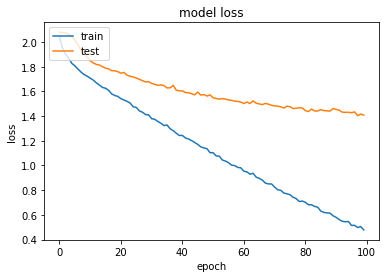

In [46]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()